In [13]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset
from strategies import LSTM_Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [15]:
naive_LSTM = LSTM_Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

In [16]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''

# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)

model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
#naive_LSTM.model.summary()

#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])

Epoch 1/20
9/9 [==============================] - 6s 196ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 2/20
9/9 [==============================] - 0s 24ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 3/20
9/9 [==============================] - 0s 24ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 4/20
9/9 [==============================] - 0s 29ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 5/20
9/9 [==============================] - 0s 31ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 6/20
9/9 [==============================] - 0s 33ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 7/20
9/9 [=============================

In [22]:
my_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

ref_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
ref_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [18]:
#pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=14):])

In [33]:
def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))

for today in BTC.history.index[naive_LSTM.input_span:-2]:
    tmr = today + tmpdelta(days=1)
    print(today, tmr)
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    print(today_data)
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

my_portfolio.update_value(up_to=pred_df.index[-1])
ref_portfolio.update_value(up_to=pred_df.index[-1])

2020-01-15 19:00:00 2020-01-16 19:00:00
date_time
2020-01-01 19:00:00    6945.02
2020-01-02 19:00:00    7334.45
2020-01-03 19:00:00    7348.63
2020-01-04 19:00:00    7355.40
2020-01-05 19:00:00    7764.63
2020-01-06 19:00:00    8158.52
2020-01-07 19:00:00    8045.51
2020-01-08 19:00:00    7813.78
2020-01-09 19:00:00    8198.09
2020-01-10 19:00:00    8020.00
2020-01-11 19:00:00    8180.81
2020-01-12 19:00:00    8104.50
2020-01-13 19:00:00    8815.69
2020-01-14 19:00:00    8808.81
2020-01-15 19:00:00    8714.76
Name: close, dtype: float64
2020-01-16 19:00:00 2020-01-17 19:00:00
date_time
2020-01-02 19:00:00    7334.45
2020-01-03 19:00:00    7348.63
2020-01-04 19:00:00    7355.40
2020-01-05 19:00:00    7764.63
2020-01-06 19:00:00    8158.52
2020-01-07 19:00:00    8045.51
2020-01-08 19:00:00    7813.78
2020-01-09 19:00:00    8198.09
2020-01-10 19:00:00    8020.00
2020-01-11 19:00:00    8180.81
2020-01-12 19:00:00    8104.50
2020-01-13 19:00:00    8815.69
2020-01-14 19:00:00    8808.81
2020

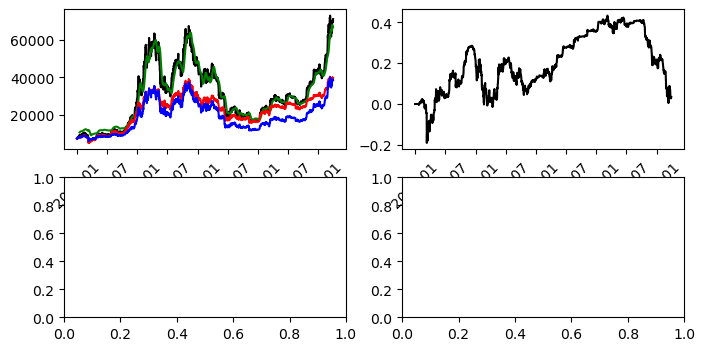

In [36]:
# Plot the results
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4)
fig.set_figwidth(8)
actual_df = BTC.history
ax[0,0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0,0].plot(pred_df.index, pred_df['Predicted price'], color = 'green', label = 'Predicted')
ax[0,0].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experimental Portfolio')
ax[0,0].plot(ref_portfolio.value.index, ref_portfolio.value['value'], color = 'blue', label = 'Reference Portfolio')
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)

ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - ref_portfolio.value['value'])/ref_portfolio.value['value'], color = 'black', label = 'ROI')
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)


In [37]:
my_portfolio.get_positions()

Reported BTC price is 25 days 16:46:37.701538 old


,position_size,position_value
ticker,,
BTC,0.305474,21776.880863
USD,18439.071775,18439.071775
